In [1]:
!pip install scikit-learn==1.2.2 imbalanced-learn==0.11.0 -q
!pip install optuna -q
!pip install optuna-integration[sklearn] -q
!pip install phik -q
!pip install lightgbm -q
!pip install catboost -q

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import (train_test_split, RandomizedSearchCV,
                                     GridSearchCV, cross_val_score)

from sklearn.preprocessing import (OneHotEncoder, LabelEncoder, OrdinalEncoder,
                                   StandardScaler, MinMaxScaler)

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import (mean_absolute_error, r2_score, mean_squared_error,
                             accuracy_score, roc_auc_score, confusion_matrix,
                             recall_score, precision_score, make_scorer)

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import (SelectKBest, mutual_info_regression,
                                       mutual_info_classif)
from optuna import distributions
from optuna.integration import OptunaSearchCV

from phik.report import plot_correlation_matrix
from phik import report
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Определение стоимости автомобилей

# Описание проекта

Сервис по продаже автомобилей с пробегом **"Не бит, не крашен"** разрабатывает приложение, которое позволит пользователям узнать рыночную стоимость своего автомобиля. Для этого необходимо построить модель, способную предсказывать стоимость автомобилей на основе данных о технических характеристиках, комплектации и ценах других автомобилей.

## Критерии, важные для заказчика

- **Качество предсказания**
- **Время обучения модели**
- **Время предсказания модели**

## Признаки данных

```
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя
```
## Целевой признак:

```
- `Price` — цена (евро)
```

## План выполнения проекта

### 1. Загрузка и изучение данных

- Загрузка данных из файла `/datasets/autos.csv`.
- Анализ структуры данных.
- Обнаружение и обработка пропущенных значений.
- Выявление и обработка аномалий.
- Удаление неинформативных признаков.

### 2. Подготовка выборок для обучения моделей

- Разделение данных на обучающую, валидационную и тестовую выборки.
- Кодирование категориальных признаков (если необходимо).
- Масштабирование числовых признаков (если необходимо).

### 3. Обучение и тестирование моделей

- Обучение различных моделей:
  - **Градиентный бустинг** (например, LightGBM).
  - **Более простые модели** (например, линейная регрессия, случайный лес и др.).
- Подбор оптимальных гиперпараметров.

### 4. Анализ характеристик моделей

- Сравнение моделей по следующим параметрам:
  - **Время обучения**.
  - **Время предсказания**.
  - **Качество предсказания** (по метрике RMSE).
- Выбор наилучшей модели в соответствии с критериями заказчика.

### 5. Проверка финальной модели

- Оценка качества выбранной модели на тестовой выборке.
- Проверка, соответствует ли значение RMSE требованию (**меньше 2500**).

### 6. Выводы и рекомендации

- Итоговый анализ проделанной работы.
- Выводы о лучших моделях и их характеристиках.
- Рекомендации по возможным улучшениям модели в будущем.

## Загрузка данных

In [3]:
data = pd.read_csv('/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [5]:
# Посмотрим, сколько обьектов в данных
shape_1 = data.shape[0]
shape_1

354369

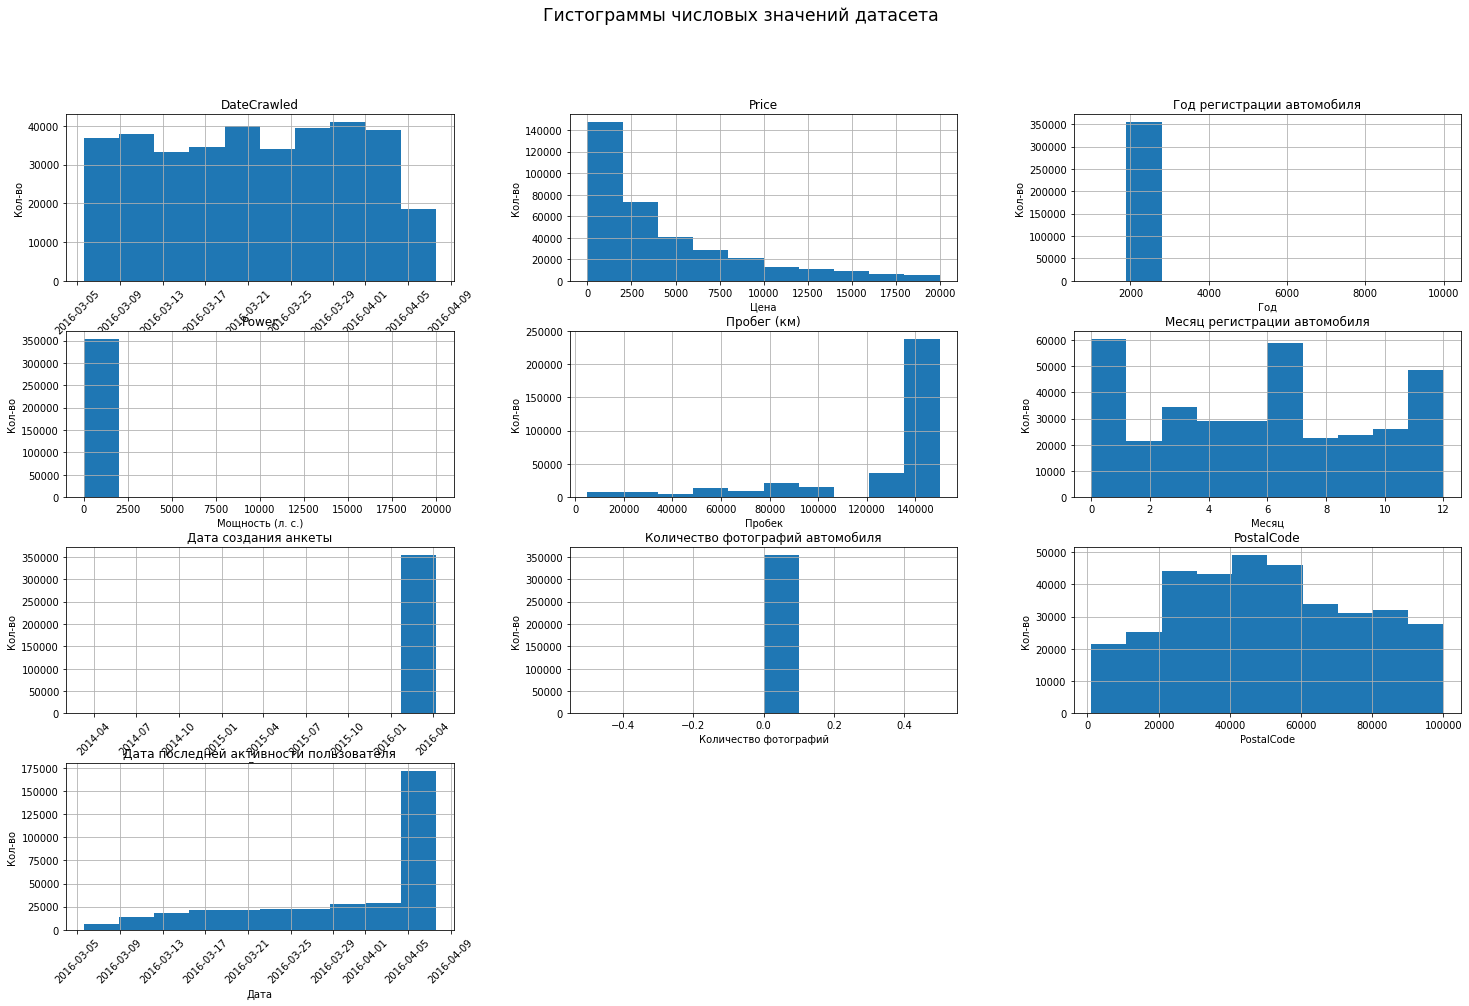

In [6]:
axes = data.hist(figsize = (25,15))
axes[0,0].set_title('DateCrawled')
axes[0,0].set_xlabel('Дата скачивания')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].set_ylabel('Кол-во')

axes[0,1].set_title('Price')
axes[0,1].set_xlabel('Цена')
axes[0,1].set_ylabel('Кол-во')

axes[0,2].set_title('Год регистрации автомобиля')
axes[0,2].set_xlabel('Год')
axes[0,2].set_ylabel('Кол-во')

axes[1,0].set_title('Power')
axes[1,0].set_xlabel('Мощность (л. с.)')
axes[1,0].set_ylabel('Кол-во')

axes[1,1].set_title('Пробег (км)')
axes[1,1].set_xlabel('Пробек')
axes[1,1].set_ylabel('Кол-во')

axes[1,2].set_title('Месяц регистрации автомобиля')
axes[1,2].set_xlabel('Месяц')
axes[1,2].set_ylabel('Кол-во')

axes[2,0].set_title('Дата создания анкеты')
axes[2,0].set_xlabel('Дата')
axes[2,0].tick_params(axis='x', rotation=45)
axes[2,0].set_ylabel('Кол-во')

axes[2,1].set_title('Количество фотографий автомобиля')
axes[2,1].set_xlabel('Количество фотографий')
axes[2,1].set_ylabel('Кол-во')

axes[2,2].set_title('PostalCode')
axes[2,2].set_xlabel('PostalCode')
axes[2,2].set_ylabel('Кол-во')

axes[3,0].set_title('Дата последней активности пользователя')
axes[3,0].set_xlabel('Дата')
axes[3,0].tick_params(axis='x', rotation=45)
axes[3,0].set_ylabel('Кол-во')

plt.suptitle('Гистограммы числовых значений датасета', ha='center', fontsize='xx-large')
plt.show()

In [7]:
# Узнаем за какой период собраны данные о машинах
print(f'Данные собраны за период с {data.DateCreated.min()} по {data.DateCreated.max()} ')

Данные собраны за период с 2014-03-10 00:00:00 по 2016-04-07 00:00:00 


In [8]:
# Посчитаем кол-во пропусков в каждом столбце
missing_count = data.isna().sum()
missing_percentage = round(data.isna().mean() * 100, 2)
missing_data = pd.concat([missing_count, missing_percentage], axis=1)
missing_data.columns = ['Пропуски', 'Доля пропусков']
missing_data = missing_data.sort_values(by='Пропуски', ascending=False)
missing_data.query('Пропуски > 0')

,Пропуски,Доля пропусков
Repaired,71154,20.08
VehicleType,37490,10.58
FuelType,32895,9.28
Gearbox,19833,5.60
Model,19705,5.56


Заметим, что пропсуки только в категориальных признаках

Данные в таблицах соответствуют описанию

Заметим, что в данных есть пропуски

В данных имеются выбросы

## Подготовка данных

### Обработка данных

In [9]:
# Приведет названия столбцов к удобному виду
data.columns = data.columns.str.lower()

In [10]:
# Посмотрим, чкакие значения принимает данный признак, чтобы определить несет ли он какую либо информацию
data['numberofpictures'].unique()

array([0])

Признак не несет информации и должен быть удален

Удалим столбцы, которые не несут никакой информации о самих автомобилях

In [11]:
# Удалим столбцы datecrawled, lastseen, postalcode, datecreated
data.drop(columns = ['datecrawled','lastseen', 'postalcode', 'datecreated', 'numberofpictures'], inplace = True)

Проверим наличие ошибок в данных и неявных дубликатов

In [12]:
# Выведем все значения категориальных признаков
for col in data.select_dtypes(include='object'):
    print(col)
    print(data[col].unique())
    print()

vehicletype
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']

gearbox
['manual' 'auto' nan]

model
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuor

Заметим, что название 'land_rover' продублировано в виде 'rover'

In [13]:
data.loc[data['brand'] == 'rover', 'brand'] = 'land_rover'

In [14]:
grouped = data.groupby('brand')['model'].unique().to_frame().reset_index()


In [15]:
# Посмотрим, какие модели каждого бренда присутсвуют в данных, что проверить есть ли неявные дубликаты в моделях
for name in data.brand.unique():
    print(name)
    print(grouped.loc[grouped['brand'] == name, 'model'].values[0])
    print()

volkswagen
['golf' 'other' 'passat' 'polo' 'scirocco' 'transporter' 'jetta' nan 'eos'
 'touran' 'lupo' 'caddy' 'tiguan' 'sharan' 'up' 'fox' 'beetle' 'touareg'
 'kaefer' 'phaeton' 'cc' 'bora' 'amarok']

audi
[nan 'a8' 'a4' 'a1' 'tt' 'a6' '80' '100' 'a3' 'a2' 'a5' 'other' '90' 'q7'
 'q3' '200' 'q5']

jeep
['grand' 'wrangler' 'cherokee' 'other' nan]

skoda
['fabia' 'yeti' 'octavia' 'roomster' 'other' nan 'superb' 'citigo']

bmw
['3er' '5er' '1er' '7er' 'z_reihe' nan '6er' 'other' 'x_reihe' 'm_reihe'
 'i3']

peugeot
['2_reihe' '3_reihe' nan 'other' '4_reihe' '1_reihe' '5_reihe']

ford
['c_max' 'ka' 'fiesta' 'escort' 'focus' 'mustang' 'mondeo' 's_max'
 'galaxy' 'other' 'transit' nan 'fusion' 'kuga' 'b_max']

mazda
['3_reihe' 'other' '6_reihe' '5_reihe' 'rx_reihe' '1_reihe' 'mx_reihe' nan
 'cx_reihe']

nissan
['navara' 'micra' 'almera' 'other' 'primera' 'juke' 'qashqai' nan
 'x_trail' 'note']

renault
['twingo' 'clio' 'kangoo' 'scenic' nan 'megane' 'r19' 'espace' 'modus'
 'other' 'laguna']



Проверим на наличие явных дубликатов

In [16]:
data.duplicated().sum()

27543

In [17]:
# Удалим дубликаты
data.drop_duplicates(inplace = True)

### Анализ данных

<br/>
<div class="alert alert-info">
Поправил
</div>

In [18]:
# Разделим признаки по типам для дальнейшего анализа и визуализации

# Категориальные признаки
string_columns = data.select_dtypes(include='object')

# Вещественные признаки
num_columns = (data.select_dtypes(include=['int64', 'float64'])).drop(['registrationmonth'], axis = 1)

# Дискретные признаки
discr_columns = ['registrationmonth']


Частотное распределение для registrationmonth:
0     34758
1     21488
2     19633
3     31675
4     27243
5     26896
6     29068
7     25225
8     20803
9     21872
10    23896
11    21995
12    22274
Name: registrationmonth, dtype: int64

Процентное соотношение:
0     10.635017
1      6.574752
2      6.007172
3      9.691701
4      8.335628
5      8.229455
6      8.894029
7      7.718174
8      6.365161
9      6.692246
10     7.311536
11     6.729881
12     6.815247
Name: registrationmonth, dtype: float64


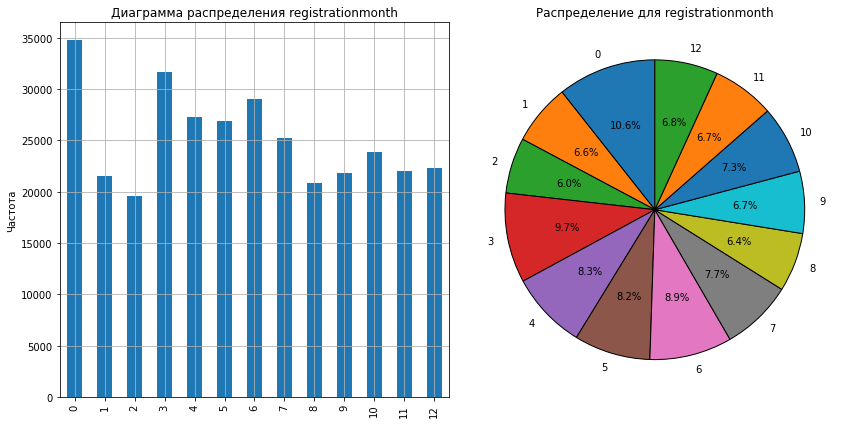


-------------------
price
count    326826.000000
mean       4403.747330
std        4518.209808
min           0.000000
25%        1000.000000
50%        2700.000000
75%        6350.000000
max       20000.000000
Name: price, dtype: float64


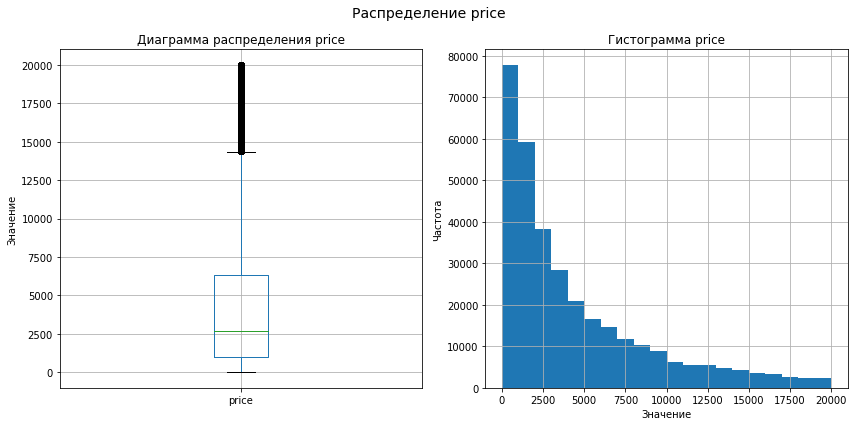


-------------------
registrationyear
count    326826.000000
mean       2004.230985
std          91.120018
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registrationyear, dtype: float64


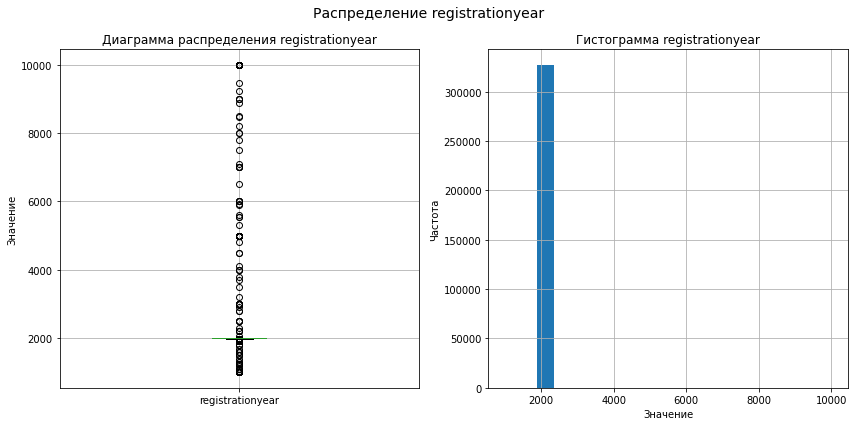


-------------------
power
count    326826.000000
mean        110.244705
std         195.886373
min           0.000000
25%          69.000000
50%         105.000000
75%         141.000000
max       20000.000000
Name: power, dtype: float64


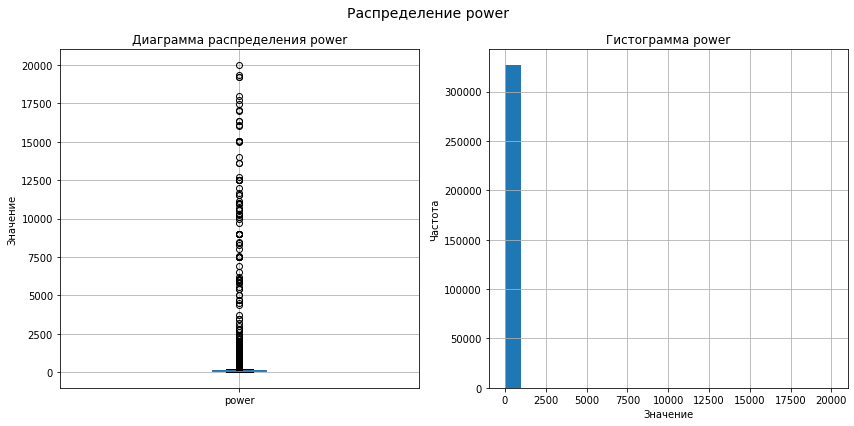


-------------------
kilometer
count    326826.000000
mean     128144.073605
std       37947.663920
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64


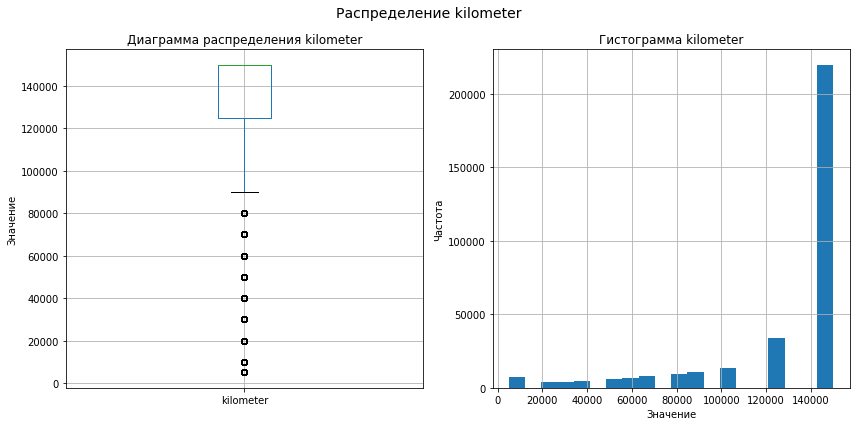


-------------------

Частотное распределение для vehicletype:
sedan          83602
small          73496
wagon          59662
bus            26795
convertible    18752
coupe          15120
suv            10977
other           3173
Name: vehicletype, dtype: int64

Процентное соотношение:
sedan          28.672358
small          25.206378
wagon          20.461833
bus             9.189682
convertible     6.431234
coupe           5.185594
suv             3.764700
other           1.088220
Name: vehicletype, dtype: float64


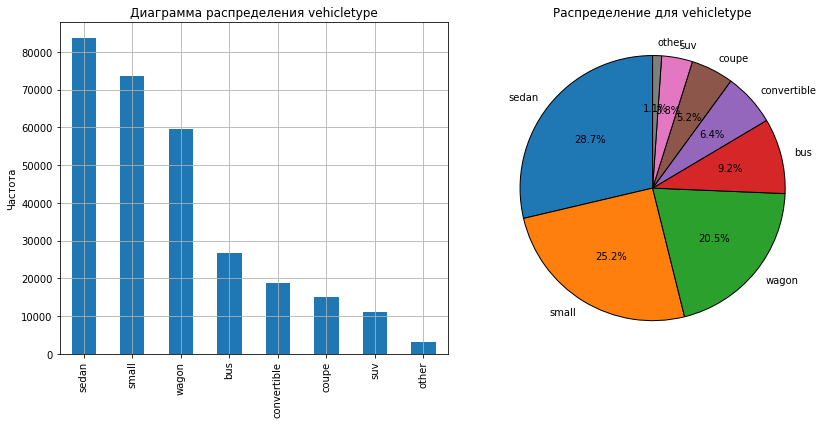


-------------------

Частотное распределение для gearbox:
manual    248135
auto       61113
Name: gearbox, dtype: int64

Процентное соотношение:
manual    80.238191
auto      19.761809
Name: gearbox, dtype: float64


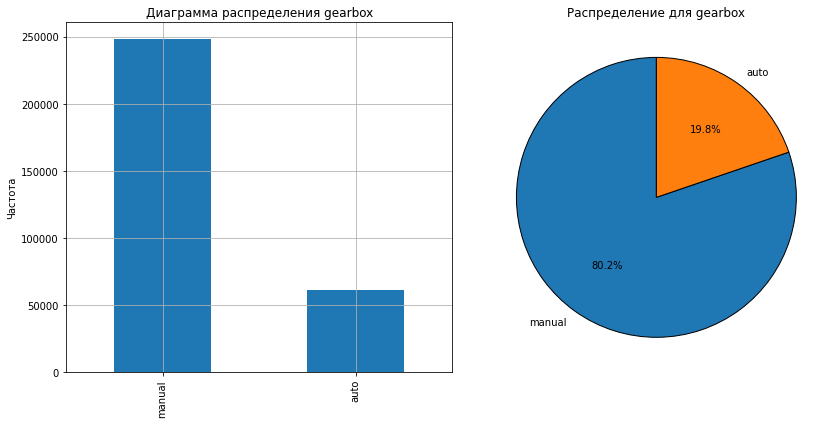


-------------------

Частотное распределение для model:
golf                  26444
other                 23231
3er                   18037
polo                  11934
corsa                 11381
                      ...  
kalina                    8
rangerover                4
serie_3                   4
serie_1                   2
range_rover_evoque        1
Name: model, Length: 250, dtype: int64

Процентное соотношение:
golf                  8.577527
other                 7.535340
3er                   5.850584
polo                  3.870980
corsa                 3.691606
                        ...   
kalina                0.002595
rangerover            0.001297
serie_3               0.001297
serie_1               0.000649
range_rover_evoque    0.000324
Name: model, Length: 250, dtype: float64


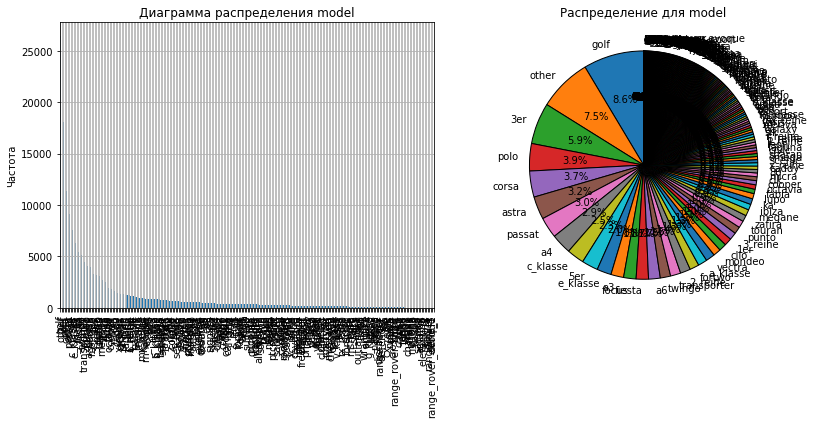


-------------------

Частотное распределение для fueltype:
petrol      200260
gasoline     89464
lpg           4934
cng            529
hybrid         228
other          200
electric        89
Name: fueltype, dtype: int64

Процентное соотношение:
petrol      67.723129
gasoline    30.254579
lpg          1.668560
cng          0.178895
hybrid       0.077104
other        0.067635
electric     0.030098
Name: fueltype, dtype: float64


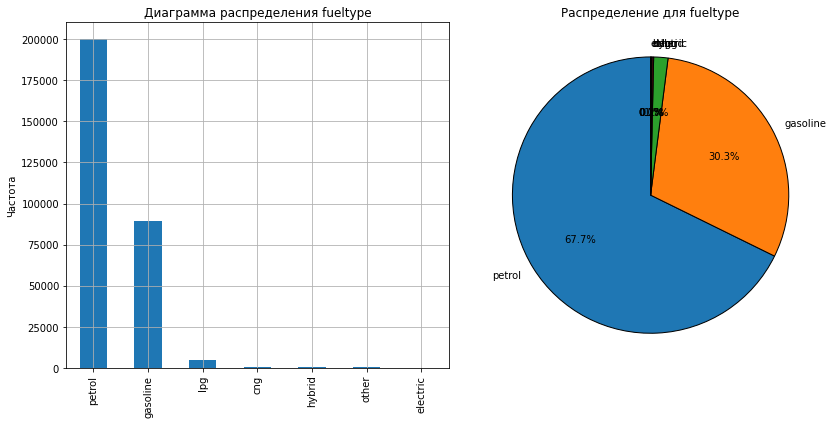


-------------------

Частотное распределение для brand:
volkswagen        69992
opel              36748
bmw               33748
mercedes_benz     29790
audi              26855
ford              23418
renault           16697
peugeot           10183
fiat               8999
seat               6423
mazda              5262
skoda              5092
smart              4935
citroen            4866
nissan             4628
toyota             4348
hyundai            3352
sonstige_autos     2995
volvo              2962
mini               2947
mitsubishi         2865
honda              2689
kia                2284
suzuki             2189
alfa_romeo         2182
chevrolet          1657
chrysler           1368
land_rover          970
dacia               841
daihatsu            763
subaru              731
porsche             706
jeep                645
trabant             557
daewoo              513
saab                488
jaguar              479
lancia              446
lada                213
Name: b

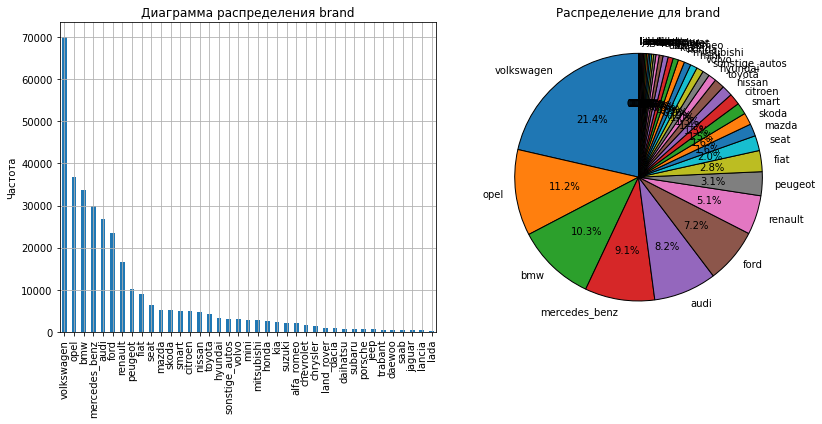


-------------------

Частотное распределение для repaired:
no     225970
yes     34429
Name: repaired, dtype: int64

Процентное соотношение:
no     86.778367
yes    13.221633
Name: repaired, dtype: float64


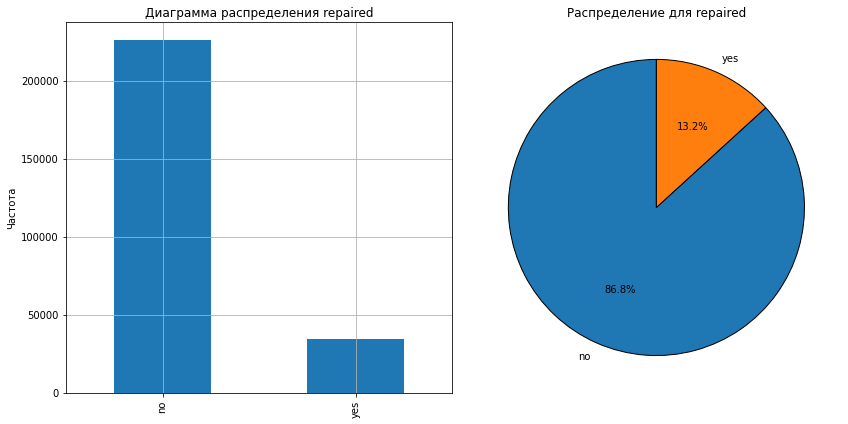


-------------------


In [19]:
# Визуализации для дискретных признаков
for col in discr_columns:
    print(f"\nЧастотное распределение для {col}:")
    print(data[col].value_counts().sort_index() )
    print("\nПроцентное соотношение:")
    print(data[col].value_counts(normalize=True).sort_index() * 100) 

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    # bar plot
    data[col].value_counts().sort_index().plot.bar(ax=axes[0])
    axes[0].set_title(f'Диаграмма распределения {col}', fontsize=12)
    axes[0].grid(True)
    axes[0].set_ylabel('Частота')
    axes[0].tick_params(axis='x', rotation=90)
    # pie chart
    data[col].value_counts().sort_index().plot.pie(
        autopct='%1.1f%%', 
        startangle=90, 
        wedgeprops={'edgecolor': 'black', 'linewidth': 1},
        ax=axes[1]
    )
    axes[1].set_title(f'Распределение для {col}', fontsize=12)
    axes[1].set_ylabel('')
    
    plt.tight_layout()
    plt.show()
    print("\n-------------------")
    
# Визуализации для вещественных признаков
for col in num_columns:
    print(col)
    print(data[col].describe())
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    # box plot
    data[col].plot.box(ax=axes[0])
    axes[0].set_title(f'Диаграмма распределения {col}')
    axes[0].grid(True)
    axes[0].set_ylabel('Значение')
    # histogram
    data[col].plot.hist(bins=20, ax=axes[1])
    axes[1].set_title(f'Гистограмма {col}')
    axes[1].grid(True)
    axes[1].set_ylabel('Частота')
    axes[1].set_xlabel('Значение')
    
    plt.suptitle(f'Распределение {col}', fontsize=14)
    plt.tight_layout()
    plt.show()
    print("\n-------------------")

# Визуализации для категориальных признаков
for col in string_columns:
    print(f"\nЧастотное распределение для {col}:")
    print(data[col].value_counts())
    print("\nПроцентное соотношение:")
    print(data[col].value_counts(normalize=True) * 100)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    # bar plot
    data[col].value_counts().plot.bar(ax=axes[0])
    axes[0].set_title(f'Диаграмма распределения {col}', fontsize=12)
    axes[0].grid(True)
    axes[0].set_ylabel('Частота')
    axes[0].tick_params(axis='x', rotation=90)
    # pie chart
    data[col].value_counts().plot.pie(
        autopct='%1.1f%%', 
        startangle=90, 
        wedgeprops={'edgecolor': 'black', 'linewidth': 1},
        ax=axes[1]
    )
    axes[1].set_title(f'Распределение для {col}', fontsize=12)
    axes[1].set_ylabel('')
    
    plt.tight_layout()
    plt.show()
    print("\n-------------------")

### Промежуточные выводы
* Месяца 0 не существует, вероятно этим значением заполнили пропуски
* Удалены столбцы не несущие информаию о машинах
* В столбце `'registrationyear'` присутствуют выбросы
* В столбце `'power'` присутствуют выбросы
* В столбце `'fueltype'` можно обьединить категории в одну
* В категориальных признаках присутствуют пропуски, которые из-за особенностей датасета седует заполнить 'unknown'

In [20]:
# Заполняем пропуски 'unknown'
data=data.fillna('unknown')

In [21]:
# В столбце 'fueltype' можно обьединим категории в одну
data['fueltype'] = data['fueltype'].replace({
    'gasoline': 'petrol',
    'lpg': 'other',  # Объединяем 'lpg' в 'other'
    'cng': 'other',  # Объединяем 'cng' в 'other'
    'hybrid': 'other',  # Объединяем 'hybrid' в 'other'
    'electric': 'other'  # Объединяем 'electric' в 'other'
})

Нам важно, чтобы модель отражала реальную ценовую ситуацию на рынке, а раритетые и старые модели имеют отличное от современного ценообразование, потому следует отсеять машины старше 40 лет, а так же машины, год регистрации которых указан после 2016 года

In [22]:
data = data.query('registrationyear > 1970 & registrationyear <= 2016')

Т.к нам важно, чтобы модель работала с массовыми автомобилями, то удалим слишком большие и слишком маленькие значения

In [23]:
data = data.query('power > 40 & power  <= 500')

Вряд ли машины отдают просто так, поэтому модель не должная обучаться на слишком низкаих ценах, поэтому оставим только машины стоимостью больше 500

In [24]:
data = data.query('price  >= 500')

Еще раз посмотрим на вазуализацию признаков

In [25]:
string_columns = data.select_dtypes(include='object')
num_columns = (data.select_dtypes(include=['int64', 'float64'])).drop(['registrationmonth'], axis = 1)
discr_columns = ['registrationmonth']


Частотное распределение для registrationmonth:
0     13494
1     17386
2     16271
3     26314
4     22433
5     22206
6     23961
7     20796
8     17175
9     18348
10    20002
11    18412
12    18365
Name: registrationmonth, dtype: int64

Процентное соотношение:
0      5.288384
1      6.813684
2      6.376708
3     10.312624
4      8.791635
5      8.702672
6      9.390468
7      8.150084
8      6.730992
9      7.190698
10     7.838911
11     7.215780
12     7.197360
Name: registrationmonth, dtype: float64


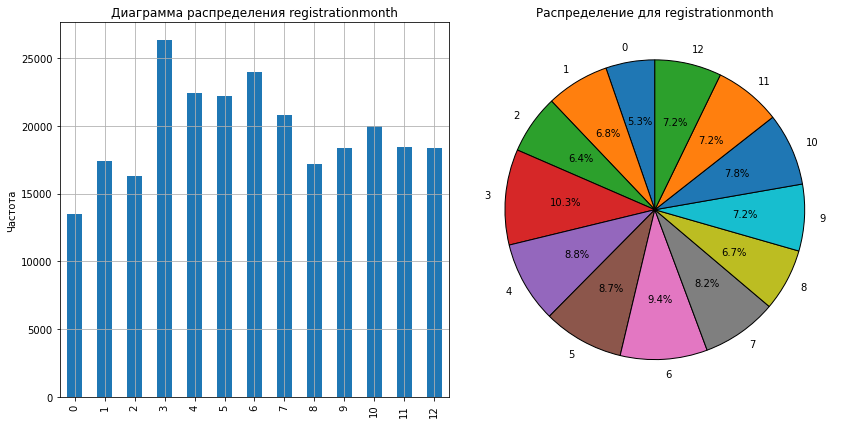


-------------------
price
count    255163.000000
mean       5116.175652
std        4604.240853
min         500.000000
25%        1500.000000
50%        3500.000000
75%        7300.000000
max       20000.000000
Name: price, dtype: float64


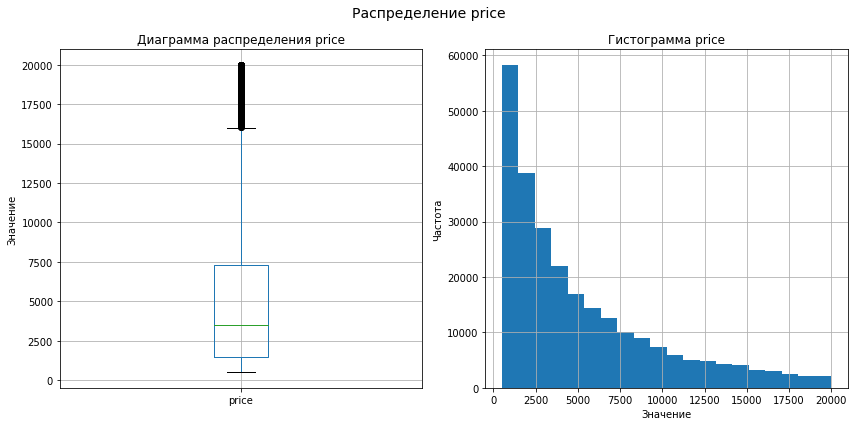


-------------------
registrationyear
count    255163.000000
mean       2003.204395
std           6.074026
min        1971.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registrationyear, dtype: float64


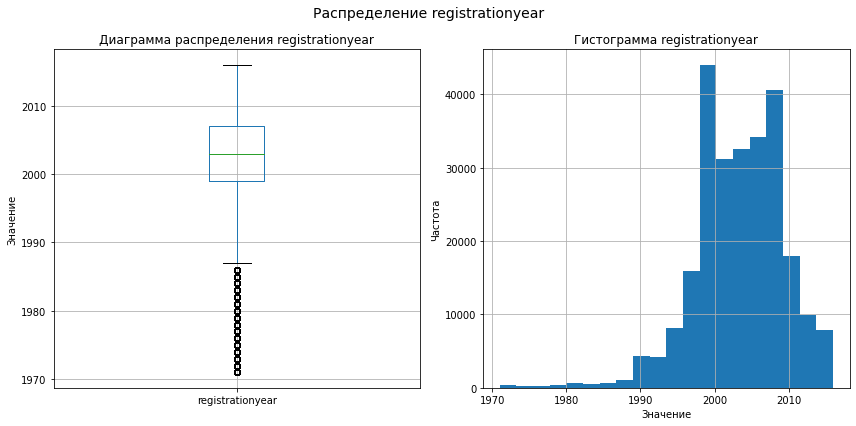


-------------------
power
count    255163.000000
mean        123.288047
std          53.128525
min          41.000000
25%          82.000000
50%         116.000000
75%         150.000000
max         500.000000
Name: power, dtype: float64


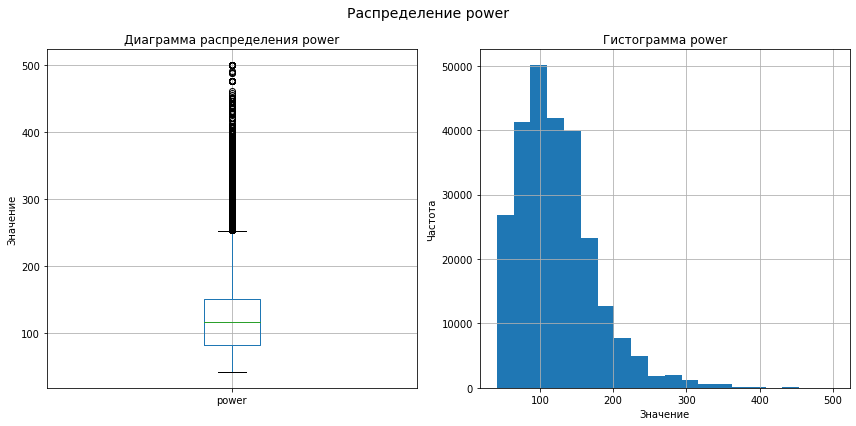


-------------------
kilometer
count    255163.000000
mean     127961.812645
std       36702.990110
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64


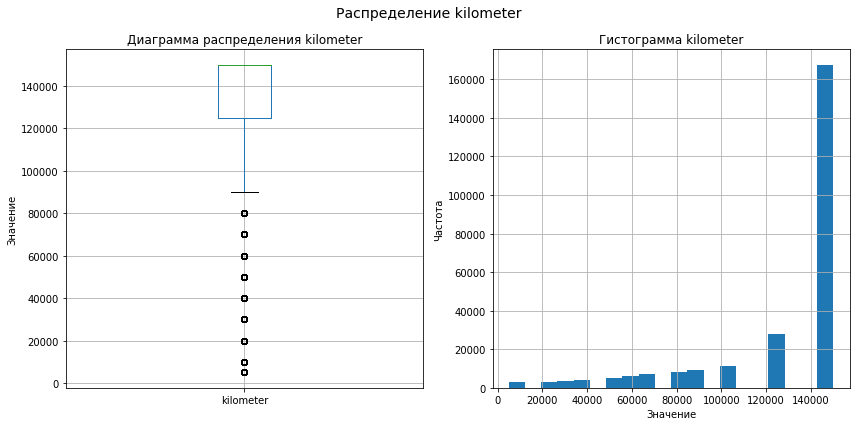


-------------------

Частотное распределение для vehicletype:
sedan          72636
small          56597
wagon          51944
bus            24008
convertible    16996
coupe          12901
suv             9888
unknown         8109
other           2084
Name: vehicletype, dtype: int64

Процентное соотношение:
sedan          28.466510
small          22.180724
wagon          20.357183
bus             9.408888
convertible     6.660840
coupe           5.055984
suv             3.875170
unknown         3.177969
other           0.816733
Name: vehicletype, dtype: float64


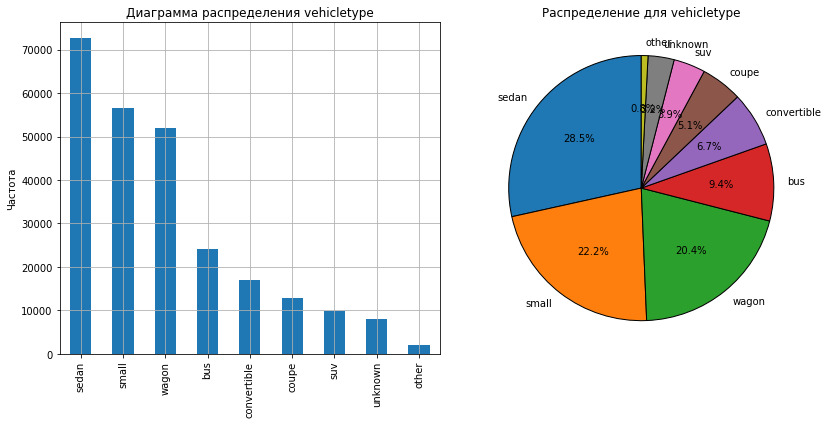


-------------------

Частотное распределение для gearbox:
manual     198235
auto        52673
unknown      4255
Name: gearbox, dtype: int64

Процентное соотношение:
manual     77.689555
auto       20.642883
unknown     1.667562
Name: gearbox, dtype: float64


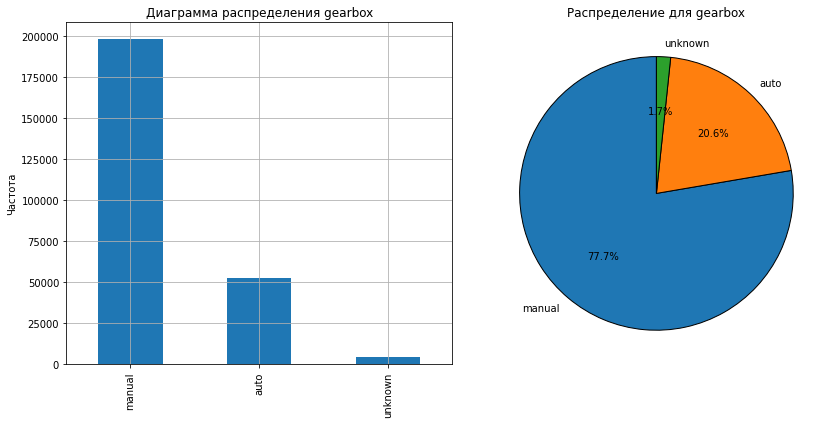


-------------------

Частотное распределение для model:
golf                  20991
other                 17693
3er                   15405
unknown                8965
polo                   8361
                      ...  
serie_2                   3
serie_3                   3
rangerover                2
601                       2
range_rover_evoque        1
Name: model, Length: 250, dtype: int64

Процентное соотношение:
golf                  8.226506
other                 6.933999
3er                   6.037317
unknown               3.513440
polo                  3.276729
                        ...   
serie_2               0.001176
serie_3               0.001176
rangerover            0.000784
601                   0.000784
range_rover_evoque    0.000392
Name: model, Length: 250, dtype: float64


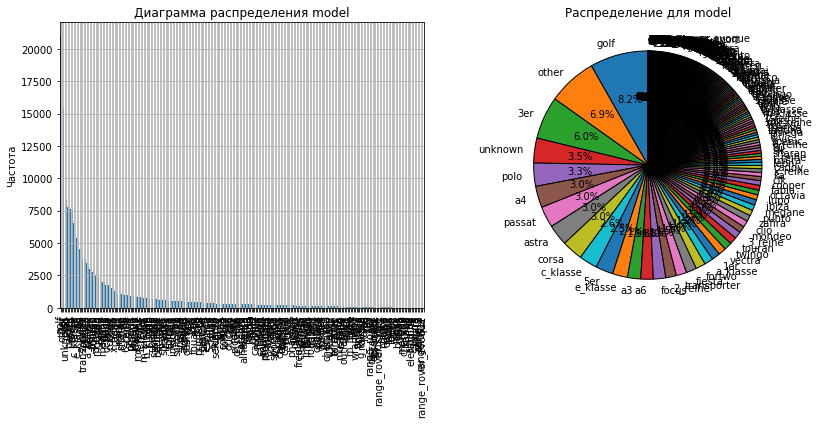


-------------------

Частотное распределение для fueltype:
petrol     237970
unknown     12251
other        4942
Name: fueltype, dtype: int64

Процентное соотношение:
petrol     93.261954
unknown     4.801245
other       1.936801
Name: fueltype, dtype: float64


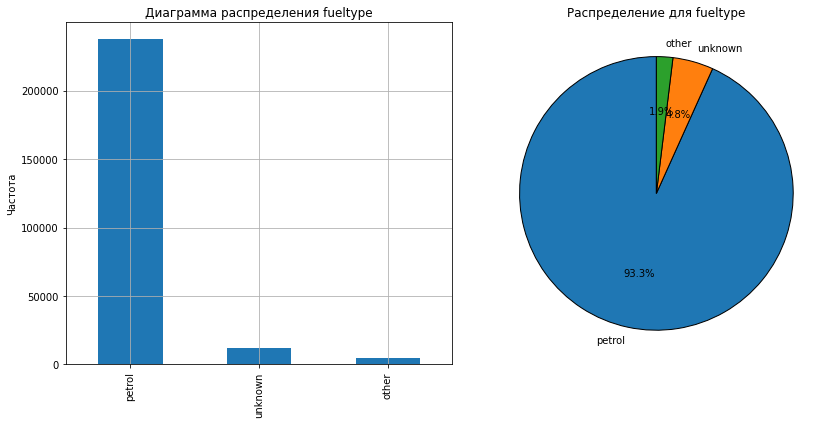


-------------------

Частотное распределение для brand:
volkswagen        54558
bmw               28805
opel              26415
mercedes_benz     25011
audi              22864
ford              16880
renault           11367
peugeot            8122
fiat               6108
seat               5018
skoda              4491
smart              4114
mazda              4104
toyota             3743
citroen            3689
nissan             3452
hyundai            2812
mini               2707
volvo              2424
honda              2137
mitsubishi         2119
kia                1879
alfa_romeo         1741
suzuki             1704
chevrolet          1339
sonstige_autos     1332
chrysler           1044
dacia               742
land_rover          714
porsche             568
subaru              551
jeep                535
daihatsu            471
saab                419
jaguar              406
daewoo              310
lancia              308
lada                146
trabant              14
Name: b

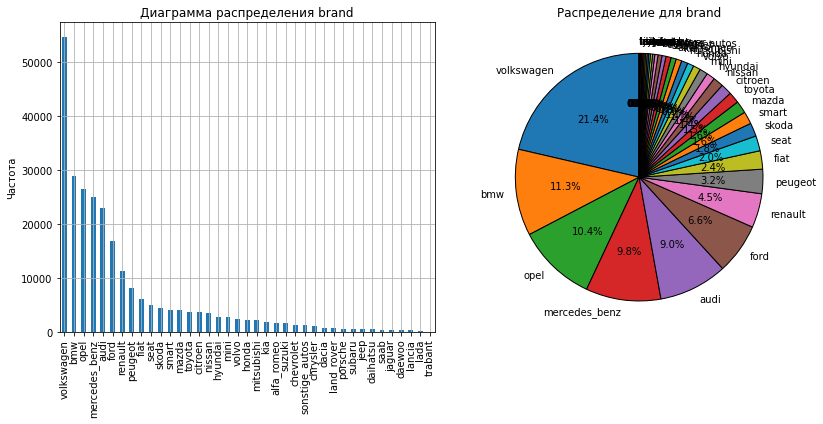


-------------------

Частотное распределение для repaired:
no         198935
unknown     34431
yes         21797
Name: repaired, dtype: int64

Процентное соотношение:
no         77.963890
unknown    13.493728
yes         8.542383
Name: repaired, dtype: float64


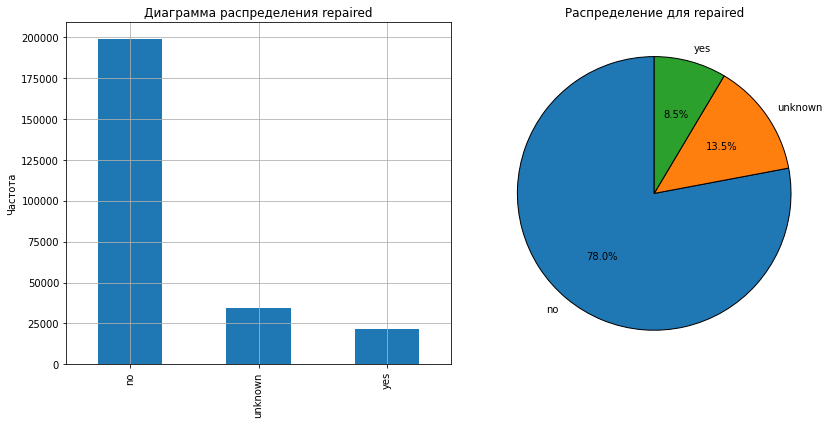


-------------------


In [26]:
for col in discr_columns:
    print(f"\nЧастотное распределение для {col}:")
    print(data[col].value_counts().sort_index() )
    print("\nПроцентное соотношение:")
    print(data[col].value_counts(normalize=True).sort_index() * 100) 

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    # bar plot
    data[col].value_counts().sort_index().plot.bar(ax=axes[0])
    axes[0].set_title(f'Диаграмма распределения {col}', fontsize=12)
    axes[0].grid(True)
    axes[0].set_ylabel('Частота')
    axes[0].tick_params(axis='x', rotation=90)
    # pie chart
    data[col].value_counts().sort_index().plot.pie(
        autopct='%1.1f%%', 
        startangle=90, 
        wedgeprops={'edgecolor': 'black', 'linewidth': 1},
        ax=axes[1]
    )
    axes[1].set_title(f'Распределение для {col}', fontsize=12)
    axes[1].set_ylabel('')
    
    plt.tight_layout()
    plt.show()
    print("\n-------------------")

for col in num_columns:
    print(col)
    print(data[col].describe())
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    # box plot
    data[col].plot.box(ax=axes[0])
    axes[0].set_title(f'Диаграмма распределения {col}')
    axes[0].grid(True)
    axes[0].set_ylabel('Значение')
    # histogram
    data[col].plot.hist(bins=20, ax=axes[1])
    axes[1].set_title(f'Гистограмма {col}')
    axes[1].grid(True)
    axes[1].set_ylabel('Частота')
    axes[1].set_xlabel('Значение')
    
    plt.suptitle(f'Распределение {col}', fontsize=14)
    plt.tight_layout()
    plt.show()
    print("\n-------------------")

for col in string_columns:
    print(f"\nЧастотное распределение для {col}:")
    print(data[col].value_counts())
    print("\nПроцентное соотношение:")
    print(data[col].value_counts(normalize=True) * 100)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    # bar plot
    data[col].value_counts().plot.bar(ax=axes[0])
    axes[0].set_title(f'Диаграмма распределения {col}', fontsize=12)
    axes[0].grid(True)
    axes[0].set_ylabel('Частота')
    axes[0].tick_params(axis='x', rotation=90)
    # pie chart
    data[col].value_counts().plot.pie(
        autopct='%1.1f%%', 
        startangle=90, 
        wedgeprops={'edgecolor': 'black', 'linewidth': 1},
        ax=axes[1]
    )
    axes[1].set_title(f'Распределение для {col}', fontsize=12)
    axes[1].set_ylabel('')
    
    plt.tight_layout()
    plt.show()
    print("\n-------------------")

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255163 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              255163 non-null  int64 
 1   vehicletype        255163 non-null  object
 2   registrationyear   255163 non-null  int64 
 3   gearbox            255163 non-null  object
 4   power              255163 non-null  int64 
 5   model              255163 non-null  object
 6   kilometer          255163 non-null  int64 
 7   registrationmonth  255163 non-null  int64 
 8   fueltype           255163 non-null  object
 9   brand              255163 non-null  object
 10  repaired           255163 non-null  object
dtypes: int64(5), object(6)
memory usage: 23.4+ MB


In [28]:
# Посмотрим сколко данных мы удалили
round((shape_1 - data.shape[0])/shape_1, 2)

0.28

### Вывод

* Месяца 0 не существует, вероятно этим значением заполнили пропуски
* У всех автомобилей нет ни одной картинки или нет информациии об их наличии, поэтому данный столбец удален
* Удалены признаки, которые никак не относятся к автомобилям
* Удалены выбросы и нереалистичные значения в признаках registrationyear и power и price
* Пропуски в категориальных переменных заполнены 'unknown'
* Данные не распределены нормально
* Данные требуют скалирования
* Удалено 28 процентов данных, но это не несет угрозы т.к их все еще много

In [29]:
data.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired
1,18300,coupe,2011,manual,190,unknown,125000,5,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,petrol,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes


## Корреляционный анализ

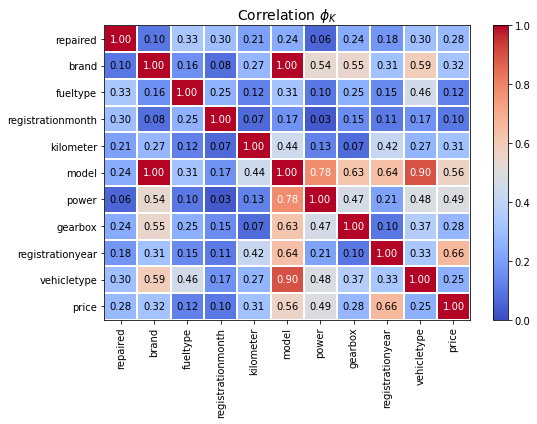

In [30]:
# т.к данные не распределены нормально, то используем матрицу phik

# Выбор числовых признаков для анализа корреляции
interval_cols = ['price', 'registrationyear', 'power', 'kilometer']

# Расчет матрицы phik
phik_overview = data.phik_matrix(interval_cols=interval_cols)

# Визуализация матрицы Pphik
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='coolwarm',
    title=r'Correlation $\phi_K$',
    figsize=(8, 6)
)

Заметим, что признаки model и brand повторяют друг друга, а значит нужно удалить признак brand т.к целевая переменная имеет низкую корреляцию (0.12) с этим признаком в отличие от признака model (0.56)

In [31]:
data.drop(columns = 'brand', inplace = True)

### Вывод

Присутствуют признаки с сильной взаимосвязью. Например, признаки model и vehicaltype имеют корреляцию 0.90, что может указывать на логическую зависимость.

## Обучение моделей

In [32]:
data.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,repaired
1,18300,coupe,2011,manual,190,unknown,125000,5,petrol,yes
2,9800,suv,2004,auto,163,grand,125000,8,petrol,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,no
4,3600,small,2008,manual,69,fabia,90000,7,petrol,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,yes


In [33]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('price', axis=1),
    data['price'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

### Создание пайплайна

In [34]:
ohe_columns = ["vehicletype", "gearbox", "fueltype", "repaired", "model"]
num_columns = ["registrationyear", "power", "kilometer", "registrationmonth"]

In [35]:
# создаём пайплайн для подготовки признаков из списка ohe_columns OHE-кодирование
ohe_pipe = Pipeline(
    [('simpleImputer_before_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)),
     ('simpleImputer_after_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
    )

# создаём пайплайн для числовых признаков
num_pipe = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', MinMaxScaler())
])

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

# Создаём итоговый пайплайн для Линейной регрессии
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),  
    ('model', LinearRegression())
])

### Обучение моеделй

In [36]:
param_grid = {
    'model': [
        DecisionTreeRegressor(random_state=RANDOM_STATE),
        LinearRegression(),
        Ridge(),
        Lasso(),
        RandomForestRegressor(random_state=RANDOM_STATE)
    ]
}

In [37]:
%%time
gridCV = GridSearchCV(
    pipe_final, 
    param_grid = param_grid, 
    cv=3,
    scoring = 'neg_root_mean_squared_error',
    n_jobs=-1,
    verbose = 10
)

CPU times: user 16 µs, sys: 2 µs, total: 18 µs
Wall time: 20.7 µs


In [38]:
%%time
gridCV.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3; 1/5] START model=DecisionTreeRegressor(random_state=42)................


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3; 1/5] END model=DecisionTreeRegressor(random_state=42);, score=-2165.726 total time=   8.0s
[CV 2/3; 1/5] START model=DecisionTreeRegressor(random_state=42)................


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3; 1/5] END model=DecisionTreeRegressor(random_state=42);, score=-2133.352 total time=   8.6s
[CV 3/3; 1/5] START model=DecisionTreeRegressor(random_state=42)................


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3; 1/5] END model=DecisionTreeRegressor(random_state=42);, score=-2170.810 total time=   7.9s
[CV 1/3; 2/5] START model=LinearRegression()....................................


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3; 2/5] END .model=LinearRegression();, score=-2557.682 total time=  12.8s
[CV 2/3; 2/5] START model=LinearRegression()....................................


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3; 2/5] END .model=LinearRegression();, score=-2562.559 total time=  13.2s
[CV 3/3; 2/5] START model=LinearRegression()....................................


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3; 2/5] END .model=LinearRegression();, score=-2571.405 total time=  17.4s
[CV 1/3; 3/5] START model=Ridge()...............................................


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3; 3/5] END ............model=Ridge();, score=-2558.190 total time=   5.0s
[CV 2/3; 3/5] START model=Ridge()...............................................


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3; 3/5] END ............model=Ridge();, score=-2562.738 total time=   4.7s
[CV 3/3; 3/5] START model=Ridge()...............................................


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3; 3/5] END ............model=Ridge();, score=-2571.208 total time=   5.0s
[CV 1/3; 4/5] START model=Lasso()...............................................


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3; 4/5] END ............model=Lasso();, score=-2595.651 total time=  13.9s
[CV 2/3; 4/5] START model=Lasso()...............................................


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3; 4/5] END ............model=Lasso();, score=-2592.201 total time=  13.0s
[CV 3/3; 4/5] START model=Lasso()...............................................


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3; 4/5] END ............model=Lasso();, score=-2599.407 total time=  13.9s
[CV 1/3; 5/5] START model=RandomForestRegressor(random_state=42)................


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3; 5/5] END model=RandomForestRegressor(random_state=42);, score=-1690.568 total time= 4.3min
[CV 2/3; 5/5] START model=RandomForestRegressor(random_state=42)................


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3; 5/5] END model=RandomForestRegressor(random_state=42);, score=-1689.509 total time= 4.3min
[CV 3/3; 5/5] START model=RandomForestRegressor(random_state=42)................


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3; 5/5] END model=RandomForestRegressor(random_state=42);, score=-1686.288 total time= 4.3min
CPU times: user 21min 22s, sys: 33.2 s, total: 21min 55s
Wall time: 22min


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_before_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse=False)),
                                                                                         ('simpleImputer_after_ohe',
                                                                                          SimpleImputer(strategy='most_frequent'))])...
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['registrationyear',
                                                                          'power',
                                                                          'kilometer',
                                                                          'registrationmonth'])])),
                                       ('model', LinearRegression())]),
             n_jobs=-1,
             param_grid={'model': [DecisionTreeRegressor(random_state=42),
                                   LinearRegression(), Ridge(), Lasso(),
                                   RandomForestRegressor(random_state=42)]},
             scoring='neg_root_mean_squared_error', verbose=10)

In [39]:
%%time
model = gridCV.best_estimator_
y_pred = model.predict(X_test)
print(f"RMSE = {mean_squared_error(y_test, y_pred, squared=False)}")

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


RMSE = 1655.4814451481761
CPU times: user 4.14 s, sys: 233 ms, total: 4.37 s
Wall time: 4.39 s


In [40]:
# Выводим полную таблицу результатов
results_df = pd.DataFrame(gridCV.cv_results_)
results_df.sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
4,253.380106,1.501885,3.835176,0.004193,RandomForestRegressor(random_state=42),{'model': RandomForestRegressor(random_state=42)},-1690.567674,-1689.509007,-1686.287770,-1688.788150,1.820096,1
0,7.523304,0.291925,0.644701,0.011818,DecisionTreeRegressor(random_state=42),{'model': DecisionTreeRegressor(random_state=42)},-2165.725939,-2133.351755,-2170.809898,-2156.629197,16.589980,2
1,13.846967,2.034668,0.628960,0.008124,LinearRegression(),{'model': LinearRegression()},-2557.681858,-2562.559445,-2571.405010,-2563.882105,5.679982,3
2,4.099407,0.141460,0.797788,0.002706,Ridge(),{'model': Ridge()},-2558.190022,-2562.737694,-2571.207580,-2564.045099,5.394206,4
3,12.796636,0.420145,0.796818,0.004082,Lasso(),{'model': Lasso()},-2595.650516,-2592.200998,-2599.406885,-2595.752800,2.942680,5


Две лучшие модели, которые показали RMSE < 2500 это RandomForestRegressor и DecisionTreeRegressor, но RandomForestRegressor обучается около 10 минут, что не подходит по критериями

RandomForestRegressor предсказывает за 4 секунды

DecisionTreeRegressor в среднем обучается за 16 секунд и показывает RMSE 2156.629197, что удовлеторяет критерии

DecisionTreeRegressor предсказывает за 0.65 секнуды

### Обучение модели LightGBM

In [41]:
for col in ohe_columns:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

In [42]:
%%time
lgbm_test = LGBMRegressor(random_state=RANDOM_STATE, objective='rmse')
lgbm_test.fit(X_train, y_train)

CPU times: user 4.05 s, sys: 22.4 ms, total: 4.07 s
Wall time: 4.05 s


LGBMRegressor(objective='rmse', random_state=42)

In [43]:
%%time
y_lgbm = lgbm_test.predict(X_train)
print(f"RMSE = {mean_squared_error(y_train, y_lgbm, squared=False)}")

RMSE = 1556.5094245424953
CPU times: user 2.03 s, sys: 0 ns, total: 2.03 s
Wall time: 2.09 s


RMSE = 1556.5094245424953

Время обучения 4 секунды

Время предсказания 2 секнуды

### Обучение модели CatBoost

In [44]:
%%time
catboost_model = CatBoostRegressor(
    loss_function='RMSE',
    random_seed=RANDOM_STATE,
    verbose=100
)
# Заполняем NaN в категориальных колонках строковым значением
# Приводим категориальные колонки к строковому типу и заполняем NaN
X_train[ohe_columns] = X_train[ohe_columns].astype(str)
X_test[ohe_columns] = X_test[ohe_columns].astype(str)


catboost_model.fit(X_train, y_train, cat_features = ohe_columns)

Learning rate set to 0.093911
0:	learn: 4327.9049728	total: 307ms	remaining: 5m 6s
100:	learn: 1782.8163139	total: 16.4s	remaining: 2m 25s
200:	learn: 1707.4744604	total: 31.8s	remaining: 2m 6s
300:	learn: 1669.5694054	total: 47s	remaining: 1m 49s
400:	learn: 1642.4735074	total: 1m 2s	remaining: 1m 33s
500:	learn: 1623.6941509	total: 1m 18s	remaining: 1m 17s
600:	learn: 1608.9434619	total: 1m 34s	remaining: 1m 2s
700:	learn: 1595.9748628	total: 1m 51s	remaining: 47.4s
800:	learn: 1584.0184169	total: 2m 7s	remaining: 31.6s
900:	learn: 1573.9904978	total: 2m 23s	remaining: 15.7s
999:	learn: 1565.2160672	total: 2m 38s	remaining: 0us
CPU times: user 2min 38s, sys: 816 ms, total: 2min 39s
Wall time: 2min 41s


In [45]:
%%time
y_catboost = catboost_model.predict(X_train)

rmse = mean_squared_error(y_train, y_catboost, squared=False)
print(f"CatBoost RMSE = {rmse}")

CatBoost RMSE = 1562.5323506366908
CPU times: user 1.39 s, sys: 7.97 ms, total: 1.4 s
Wall time: 1.41 s


RMSE = 1562.5323506366908

Время обучения 3 минуты

Время предсказания 2 секнуды

## Анализ моделей

1. Были обучены модели 
* DecisionTreeRegressor(random_state=RANDOM_STATE),
* LinearRegression(),
* Ridge(),
* Lasso(),
* RandomForestRegressor(random_state=RANDOM_STATE)

Две лучшие модели, которые показали RMSE < 2500 это RandomForestRegressor и DecisionTreeRegressor, но 
RandomForestRegressor обучается доьше других моделей, что не подходит по критериями

DecisionTreeRegressor в среднем обучается за 16 секунд и показывает RMSE 2156.629197, что удовлеторяет критерии

2. И бустинговые модели 
* LightGBM
* CatBoost

LightGBM обучается за 4 секунд и RMSE 1556.5 , что по обоим показателям лучше DecisionTreeRegressor

CatBoost имеет незначтельное отличие RMSE: 1562, но обучение занимает 3 минут

## Тестирование

Лучше моделью оказался LightGBM с низким временем обучения и предказаня, а также RMSE Удовлетворяющим условия

In [46]:
for col in ohe_columns:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

In [47]:
# Протестируем на тернировочной выборке
y_lgbm_pred = lgbm_test.predict(X_test)
print(f"RMSE = {mean_squared_error(y_test, y_lgbm_pred, squared=False)}")

RMSE = 1605.342121179183


## Вывод

**Задача. Построить модель, которая умеет определять стоимость модели машины и удовлетворяет критериям:**

**1. RMSE < 2500**

**2. Быстрое обучение модели**

**3. Быстрое предсказание модели**

* В Исходных данных содержались дубликаты и пропуски

* Исправлено дублирование бренда range_rover

* Удалены выбросы и невозможные значения из признаков

* Удалены признаки дублирующие друг друга

* СОзданы и обучены модели для предсказания стоимости автомобилей

* Лучше моделью оказался LightGBM со временем обучения 4 секунд, а также RMSE = 1605.3